In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from chromalab.observer import Observer, Cone, transformToChromaticity, getHeringMatrix
from chromalab.inks import Neugebauer, InkGamut, CellNeugebauer, Pigment, InkLibrary
from chromalab.spectra import Spectra, Illuminant
from chromalab.maxbasis import MaxBasis
from chromalab.cubemap import CubeMap

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget


In [4]:
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

In [5]:
all_inks = {}
with open(f'../data/nix/Inks_all.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        all_inks[name] = spectra
        
        
with open(f'../data/nix/02022024.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        all_inks[name] = spectra
        
with open(f'../data/nix/011624.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        try:
            spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        except ValueError:
            continue
        all_inks[name] = spectra

/Users/jessicalee/Projects/generalized-colorimetry/code/ChromaLab/chromalab/spectra.py:36: UserWarning: Data has values not between 0 and 1. Clipping.
  warnings.warn("Data has values not between 0 and 1. Clipping.")


In [6]:
cmy_primaries_dict = {}
with open(f'../data/nix/PrintColors/000.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i == 4:
            color_data = np.array(row[33:],dtype=float)
            spectra = Spectra(data=color_data, wavelengths=wavelengths10)
            cmy_primaries_dict["000"] = spectra

In [7]:
collection1 = [all_inks["Platinum violet"], 
              all_inks["Di citrus yellow"], 
              all_inks["Mg turquoise"], 
              all_inks["V maskara "],
              all_inks["Kaweco green"]]

collection2 = [all_inks["Platinum violet"], 
              all_inks["Di citrus yellow"], 
              all_inks["Mg turquoise"], 
              all_inks["V maskara "],
              all_inks["Kaweco green"], 
              all_inks["Peach haze D"]]

collection3 = [all_inks["Platinum violet"], 
              all_inks["Di citrus yellow"], 
              all_inks["Mg turquoise"], 
              all_inks["V maskara "],
              all_inks["Peach haze D"]]

collection = collection1

In [8]:
paper = cmy_primaries_dict["000"]
d65 = Illuminant.get("d65")

In [9]:
wavelengths = np.arange(390, 700, 10)
d65 = Illuminant.get("D65")

tetrachromat = Observer.tetrachromat(wavelengths=wavelengths, illuminant=d65, verbose=True) 
maxbasis = MaxBasis(tetrachromat, verbose=True)
tetra_maxbasis = maxbasis.get_max_basis_observer()

100%|██████████| 28/28 [00:00<00:00, 63.60it/s]


In [10]:
gamut = InkGamut(collection, paper, illuminant=d65)
spectral_pc, perc = gamut.get_spectral_point_cloud(tetrachromat, stepsize=0.05)

Generating point cloud: 41it [00:07,  5.16it/s]                        


In [11]:
point_cloud, perc = gamut.get_point_cloud(tetrachromat, stepsize=0.05)

Generating point cloud: 41it [00:09,  4.44it/s]                        


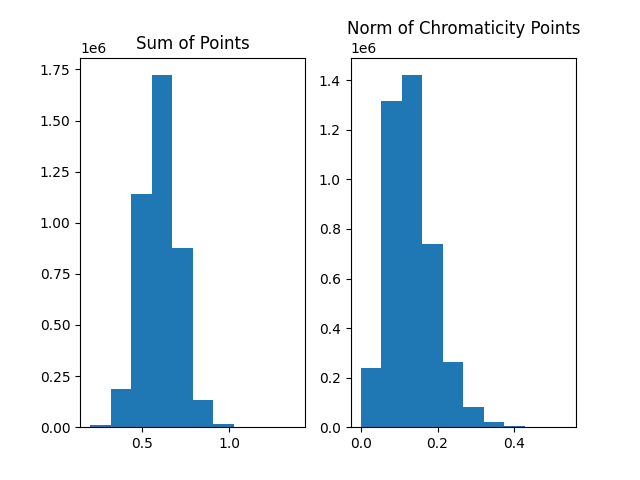

In [20]:

HMatrix = getHeringMatrix(4)

Tmat = maxbasis.get_cone_to_maxbasis_transform()
maxbasis_pts = (Tmat @ point_cloud.T).T
chrom_pts = transformToChromaticity(maxbasis_pts)
hering_max = (HMatrix@maxbasis_pts.T).T

fig, axs = plt.subplots(1, 2)

axs[0].hist(hering_max[:, 0])
axs[0].set_title('Sum of Points')
axs[1].hist(np.linalg.norm(chrom_pts, axis=1))
axs[1].set_title('Norm of Chromaticity Points')
plt.show()

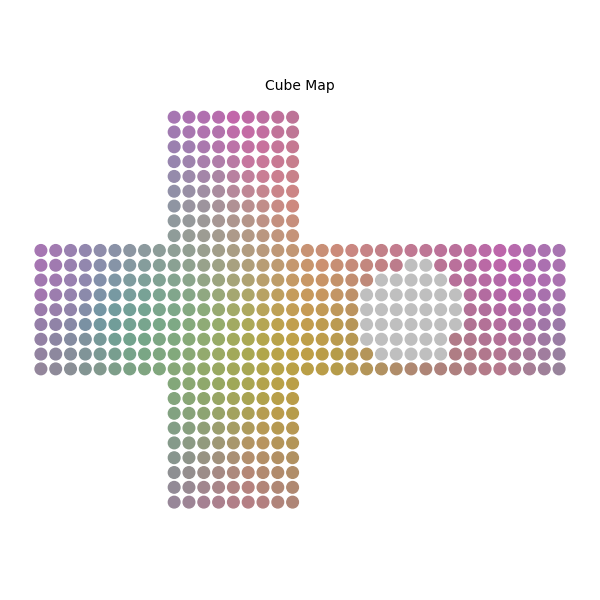

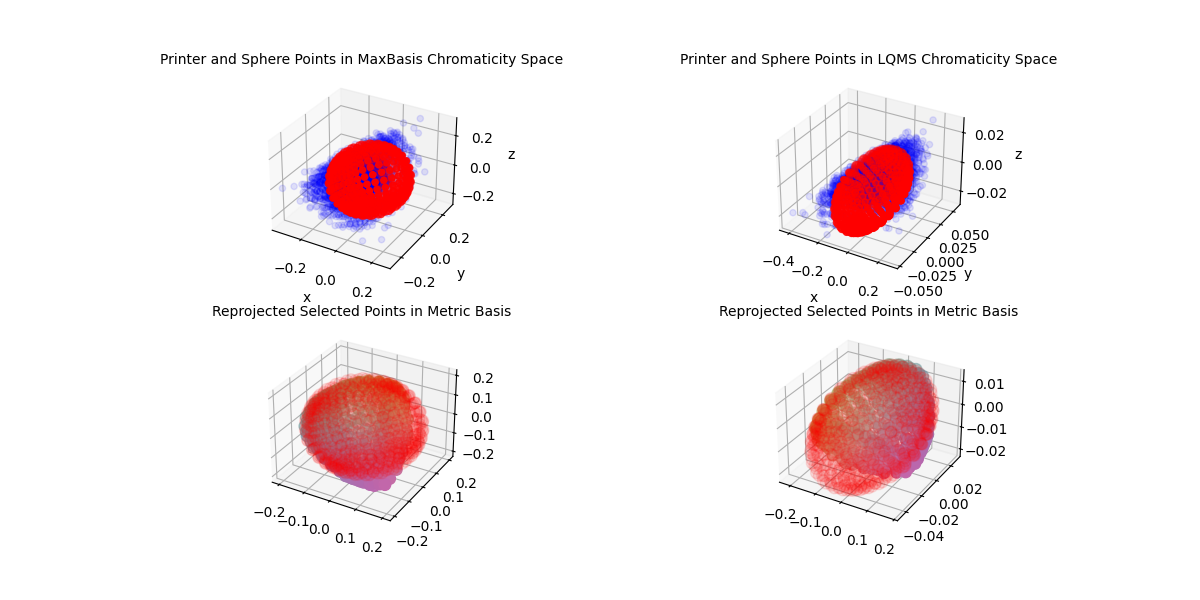

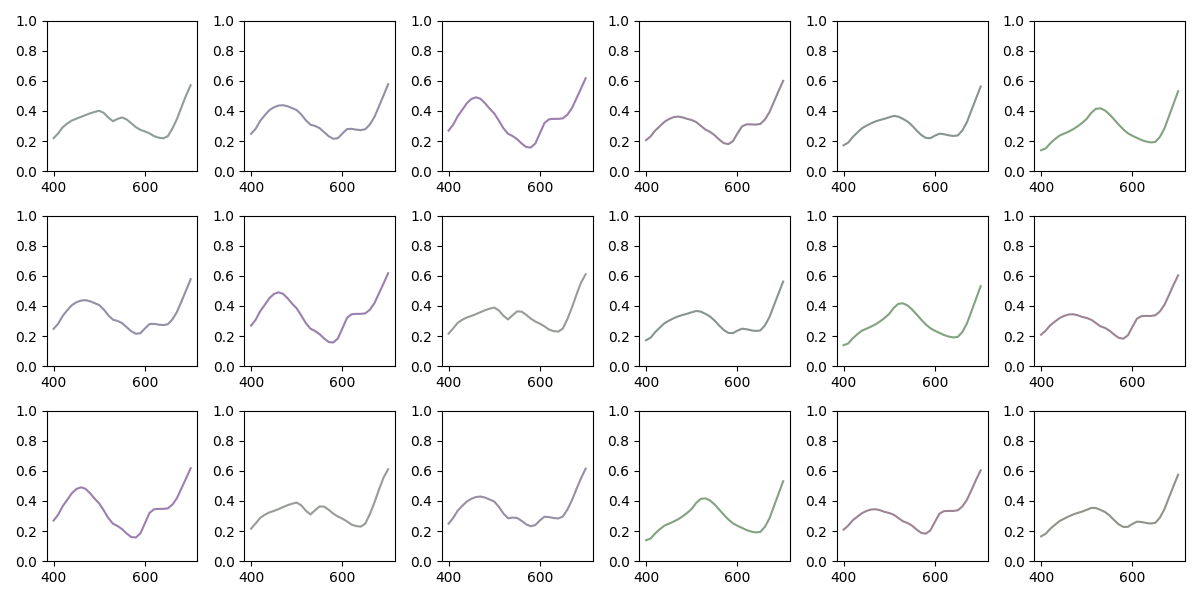

In [86]:
cubemap = CubeMap(point_cloud, maxbasis, refs=spectral_pc, ref_wavelengths= np.arange(400, 701, 10), verbose=True)
lumval = 0.5; satval = 0.2; side_len = 9
cubemap.display_detailed_cubemap(lumval, satval, side_len, method='conebasis') # method is if we choose distance to be in the cone basis or the max basis. The basis selects points but it won't be a sphere.